In [76]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt
from libpysal.weights import Kernel
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

cf.go_offline()
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')

data = gpd.read_file(DATA_DIR / 'spatial_income_1880.gpkg')
data['is_old'] = data.is_old.astype(int)
# print(data.loc[data.orthodox_proportion.isna()])
data = data.dropna().reset_index()
# W = Kernel.from_dataframe(data, fixed=True, bandwidth=150, function='quartic')
xy = np.array([data.geometry.x, data.geometry.y]).T
d = distance_matrix(xy, xy)
d_norm = d / d.max()
n = data.shape[0]

In [83]:
N_COMPONENTS = 6
variables = ['lutheran', 'orthodox', 'is_old', 'total_income_ln',
             'orthodox_proportion', 'income_per_capita_ln']
X = StandardScaler().fit_transform(data.loc[:, variables])
pca = PCA(n_components=N_COMPONENTS).fit(X)
components = pd.DataFrame(pca.components_.T, index=variables)

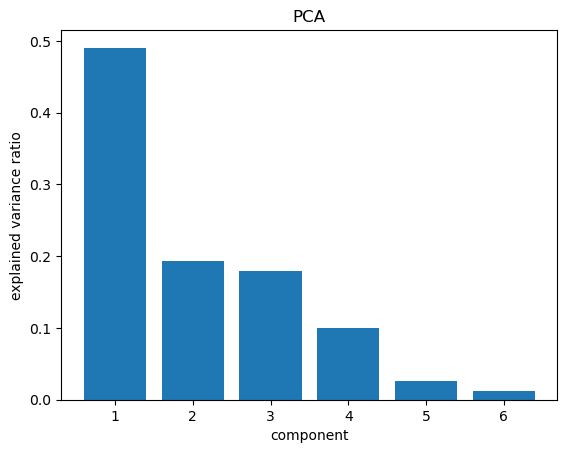

In [84]:
_, ax = plt.subplots()
ax.bar(height=pca.explained_variance_ratio_, x=list(range(1, N_COMPONENTS + 1)))
ax.set_title('PCA')
ax.set_ylabel('explained variance ratio')
ax.set_xlabel('component')
ax.set_xticks(list(range(1, N_COMPONENTS + 1)))
plt.show()

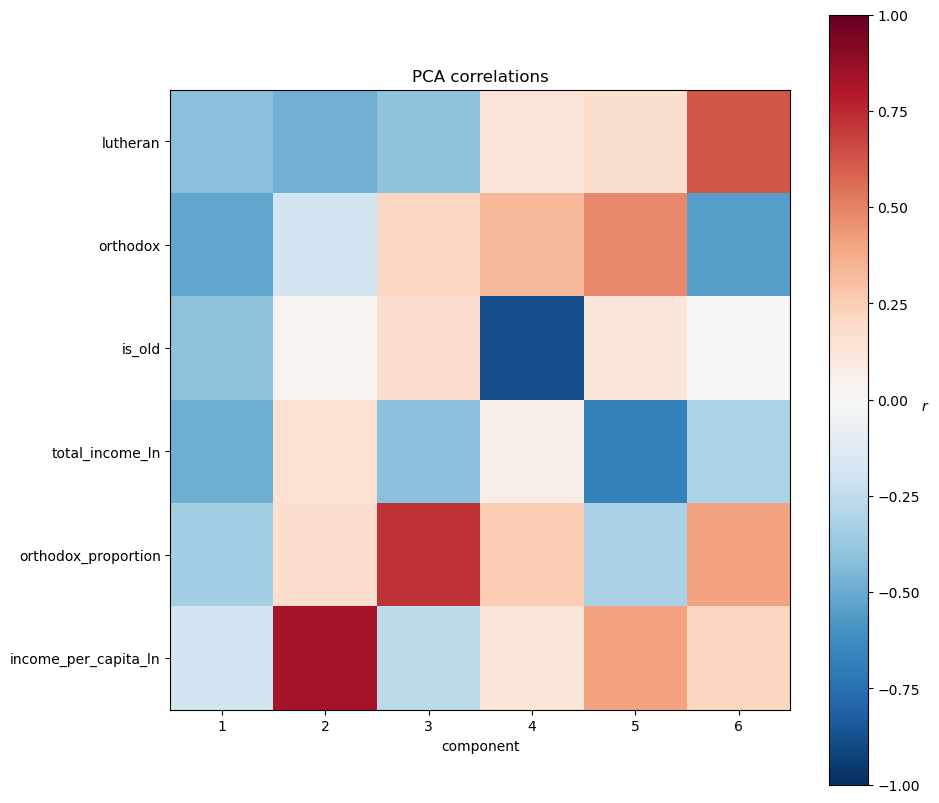

In [85]:
_, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(components, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('PCA correlations')
ax.set_xlabel('component')
ax.set_yticks(list(range(len(variables))))
ax.set_yticklabels(variables)
ax.set_xticks(list(range(N_COMPONENTS)))
ax.set_xticklabels(list(range(1, N_COMPONENTS + 1)))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)

plt.show()

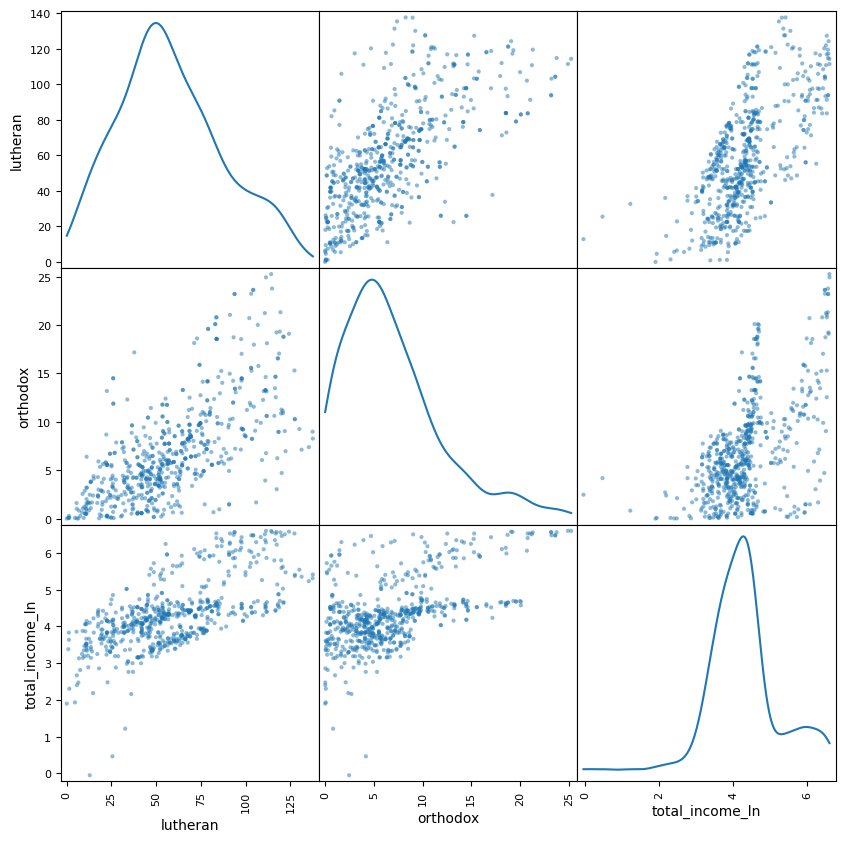

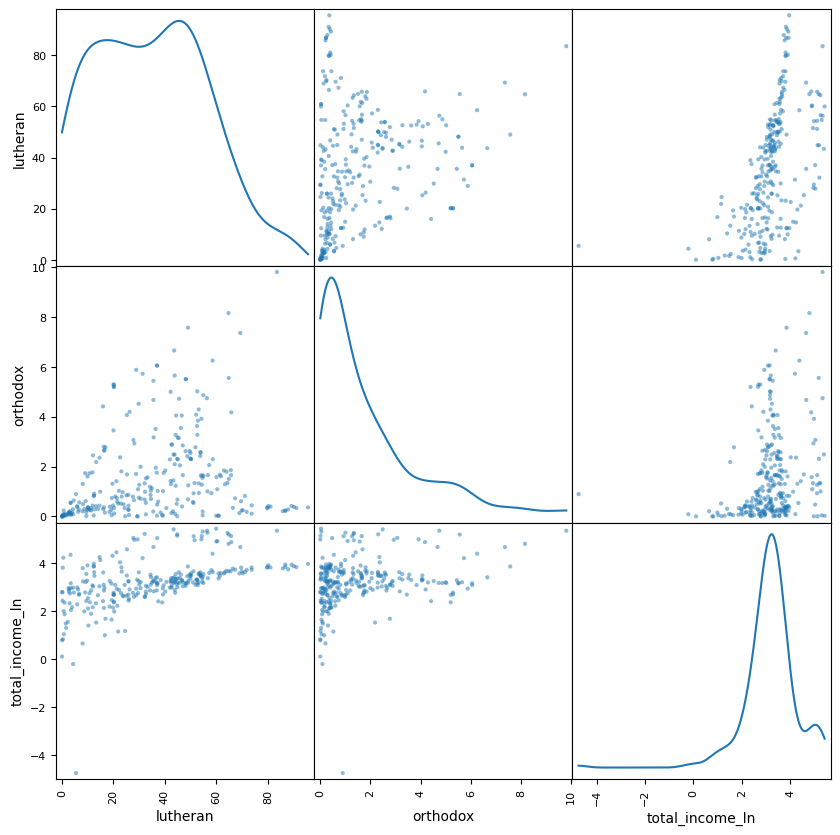

In [86]:
for i in data.is_old.unique():
    scatter_matrix(data.loc[data.is_old == i, ['lutheran', 'orthodox', 'total_income_ln']], diagonal='kde', figsize=(10, 10))

<AxesSubplot:>

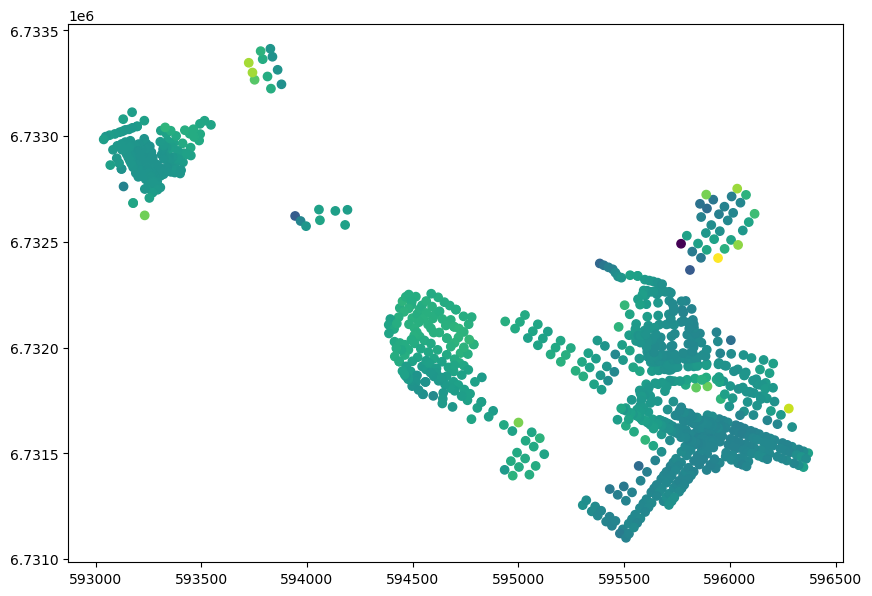

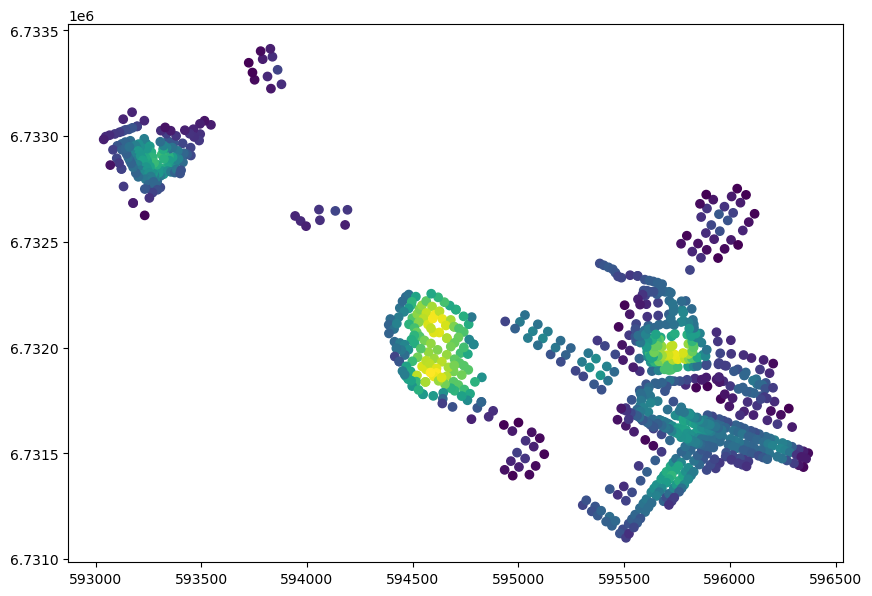

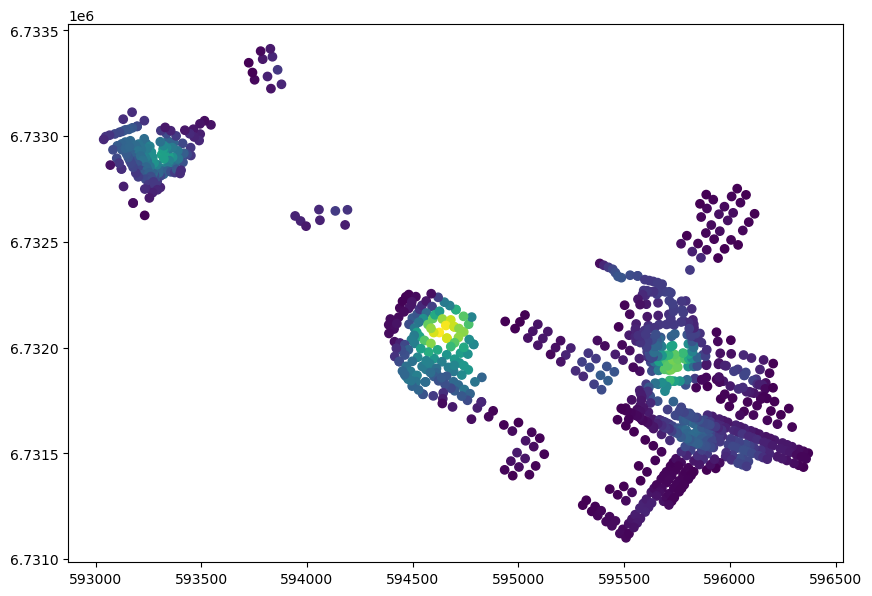

In [31]:
data.plot(column='income_per_capita_ln', figsize=(10,10))
data.plot(column='population', figsize=(10,10))
data.plot(column='orthodox', figsize=(10,10))

In [32]:
# data.loc[data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
# plt.show()
# data.loc[~data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
# data.hist(column='orthodox')
# data.hist(column='population')
# data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
# data.hist(column='orthodox_proportion_ln', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

In [33]:
with pm.Model() as model_1:
    W = pm.MutableData('W', data.total_income_ln)

    β_P = pm.MvNormal('β_P', np.array([2.5, 0]), np.array(np.diagflat([0.1, 0.01])), shape=2)

    μ_P = pm.Deterministic('μ_P', pm.math.exp(β_P[0] + β_P[1] * W))

    σ_P = pm.Gamma('σ_P', 4, 2)
    P = pm.Gamma('P', mu=μ_P, sigma=σ_P, observed=data.population)

    β_O = pm.MvNormal('β_O', np.array([1, 0, 0]), np.array(np.diagflat([0.1, 0.01, 0.01])), shape=3)

    μ_O = pm.math.exp(β_O[0] + β_O[1] * W + β_O[2] * μ_P)
    σ_O = pm.Gamma('σ_O', 10, 2)
    O = pm.Gamma('O', mu=μ_O, sigma=σ_O, observed=data.orthodox)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_P, σ_P, β_O, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 168 seconds.
The acceptance probability does not match the target. It is 0.885, but should be close to 0.8. Try to increase the number of tuning steps.


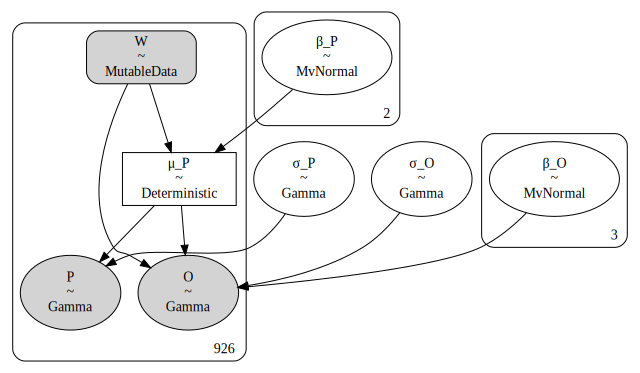

In [34]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

array([<AxesSubplot:xlabel='P / P'>, <AxesSubplot:xlabel='O / O'>],
      dtype=object)

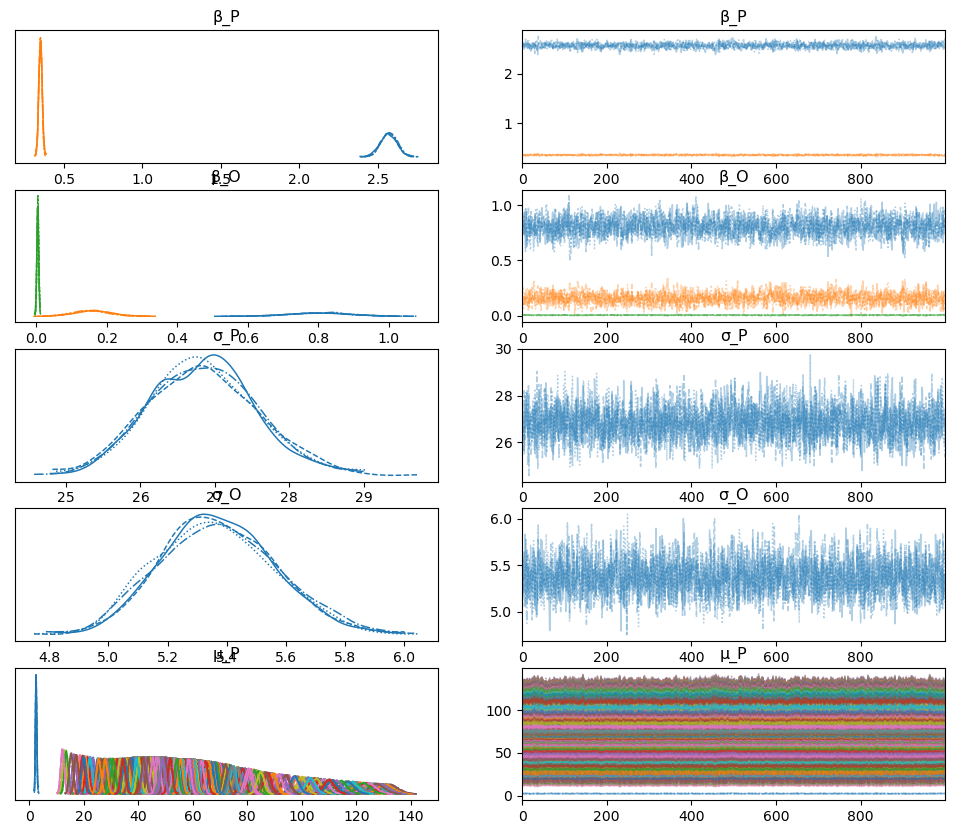

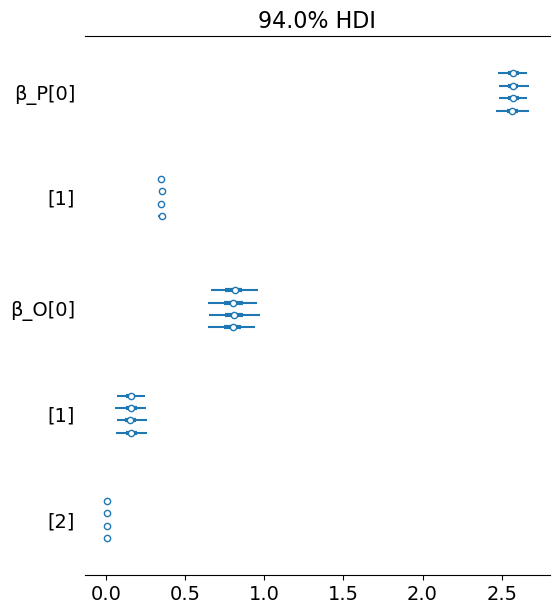

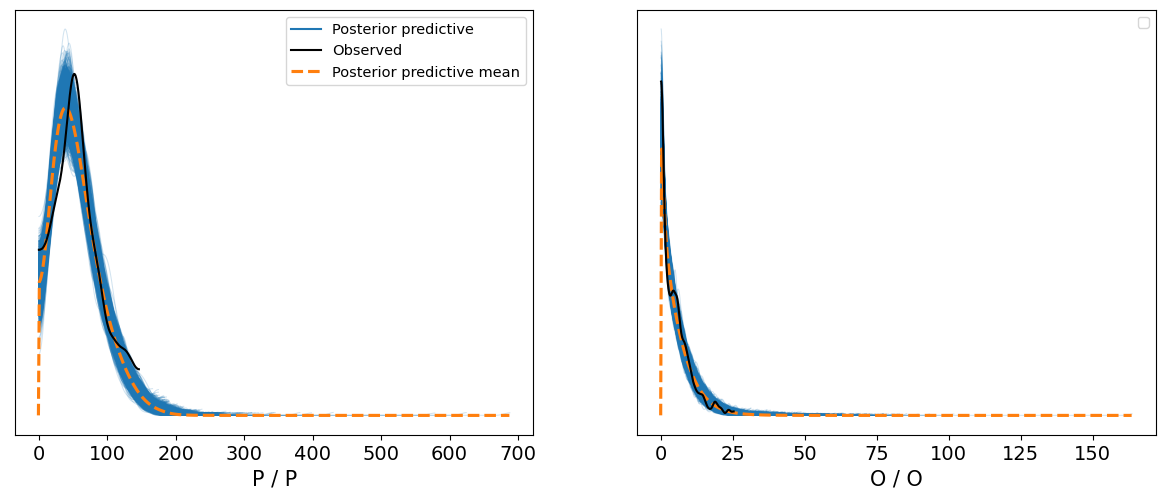

In [35]:
# az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
az.plot_forest(posterior_1, combined=False, hdi_prob=0.94, var_names=['~σ_P', '~σ_O', '~μ_P'])

az.plot_ppc(posterior_prediction_1)

In [36]:
with pm.Model() as model_2:
    W = pm.MutableData('W', data.total_income_ln)
    idx = data.is_old

    θ_P = pm.MvNormal('θ_P', np.array([2.5, 0]), np.array(np.diagflat([0.1, 0.01])), shape=2)
    θ_O = pm.MvNormal('θ_O', np.array([1, 0, 0]), np.array(np.diagflat([0.1, 0.01, 0.01])), shape=3)

    β_P = pm.MvNormal('β_P', θ_P, np.array(np.diagflat([0.1, 0.01])), shape=(2, 2))
    β_O = pm.MvNormal('β_O', θ_O, np.array(np.diagflat([0.1, 0.01, 0.01])), shape=(2, 3))

    μ_P = pm.Deterministic('μ_P', pm.math.exp(β_P[idx, 0] + β_P[idx, 1] * W))

    σ_P = pm.Gamma('σ_P', 4, 2)
    P = pm.Gamma('P', mu=μ_P, sigma=σ_P, observed=data.population)

    μ_O = pm.math.exp(β_O[idx, 0] + β_O[idx, 1] * W + β_O[idx, 2] * μ_P)
    σ_O = pm.Gamma('σ_O', 10, 2)
    O = pm.Gamma('O', mu=μ_O, sigma=σ_O, observed=data.orthodox)

    prior_2 = pm.sample_prior_predictive()
    posterior_2 = pm.sample(draws=1000, tune=1000, init="adapt_diag", return_inferencedata=True, target_accept=0.9)
    posterior_prediction_2 = pm.sample_posterior_predictive(posterior_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_P, θ_O, β_P, β_O, σ_P, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1346 seconds.


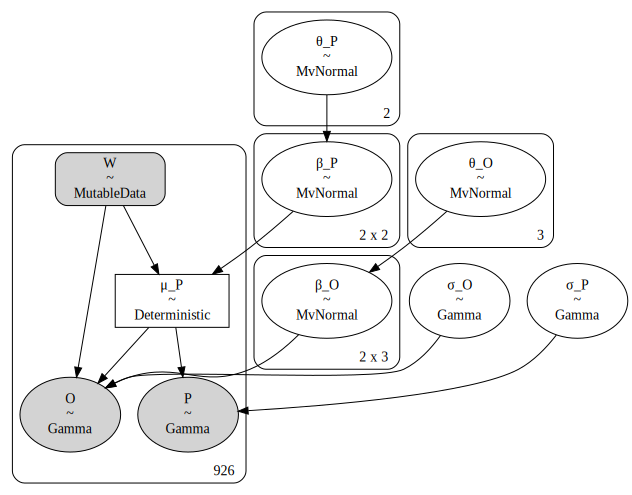

In [37]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

array([<AxesSubplot:xlabel='P / P'>, <AxesSubplot:xlabel='O / O'>],
      dtype=object)

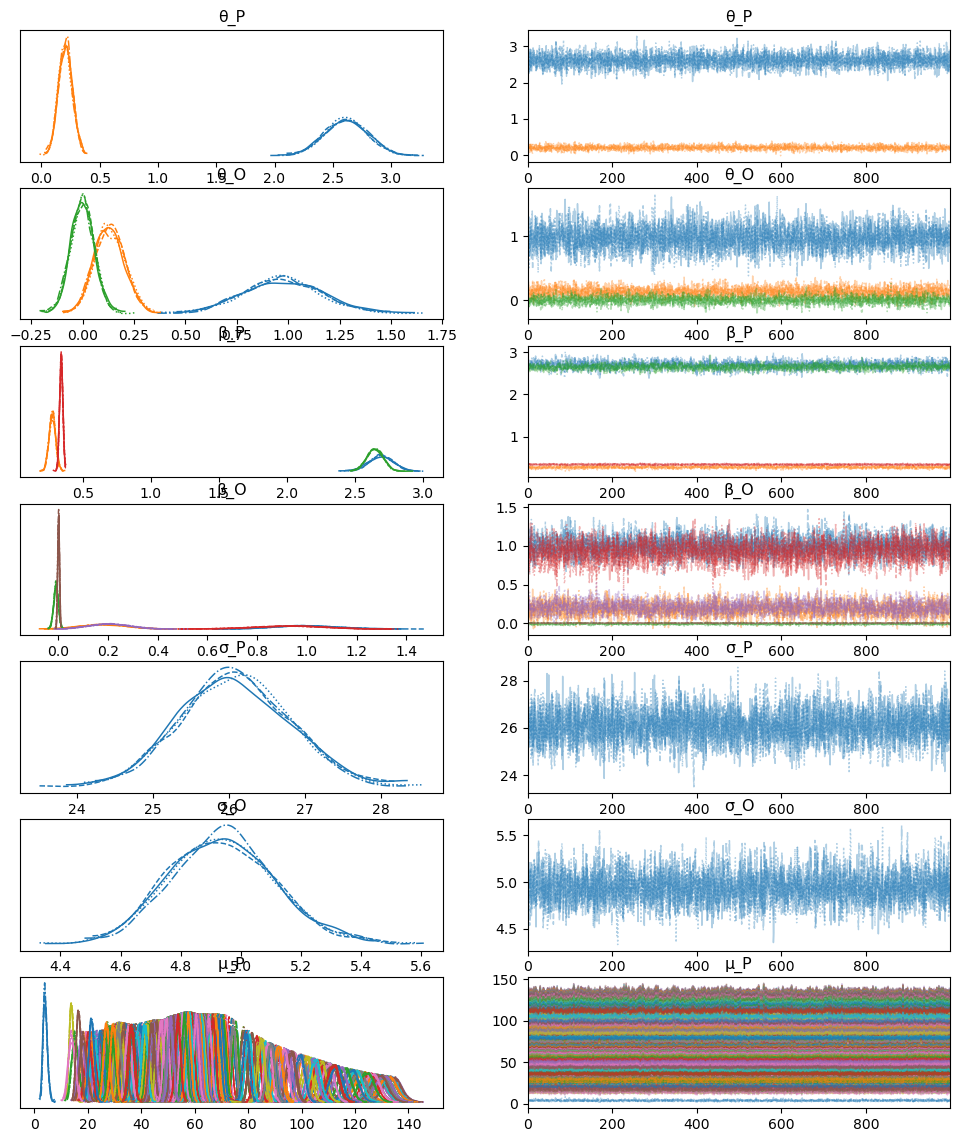

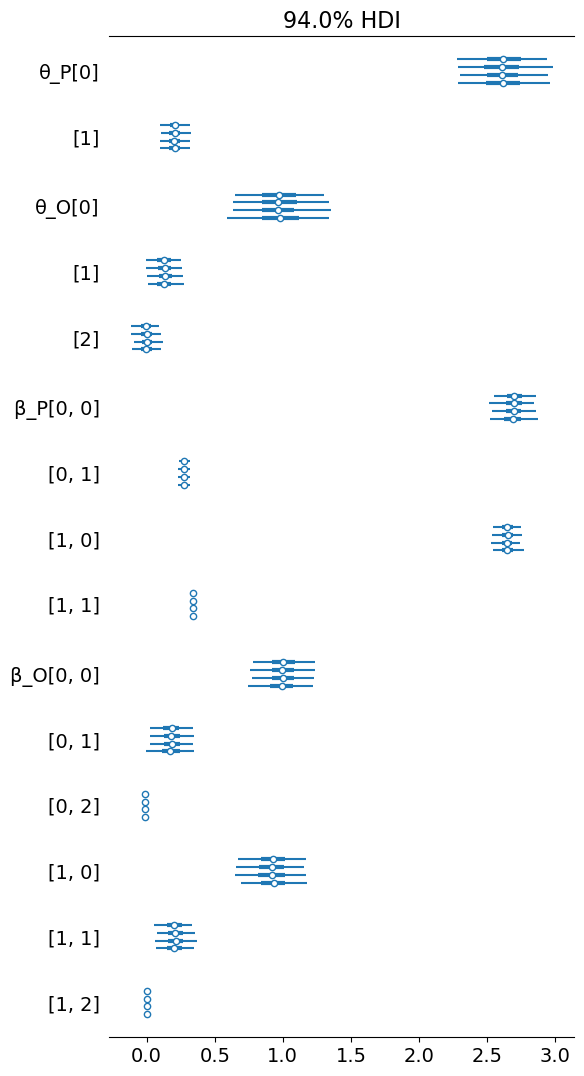

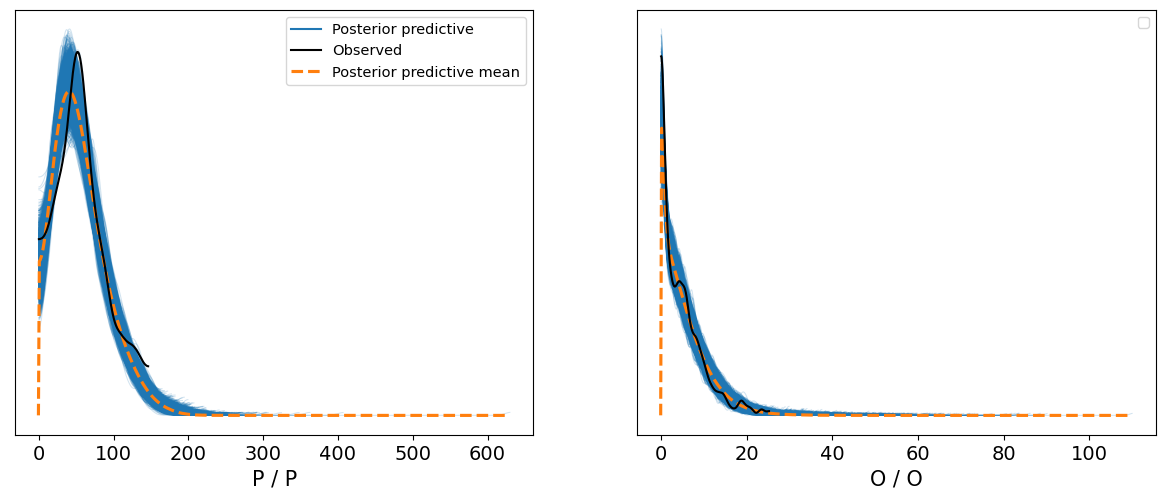

In [38]:
# az.plot_posterior(posterior_2)
az.plot_trace(posterior_2)
az.plot_forest(posterior_2, combined=False, hdi_prob=0.94, var_names=['~σ_P', '~σ_O', '~μ_P'])

az.plot_ppc(posterior_prediction_2)

# Clustering

In [3]:
SEED = 42
N_CLUSTERS = 12
cluster_colors = plt.get_cmap('tab20')

groups = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit_predict(xy)
data['group'] = groups

<AxesSubplot:>

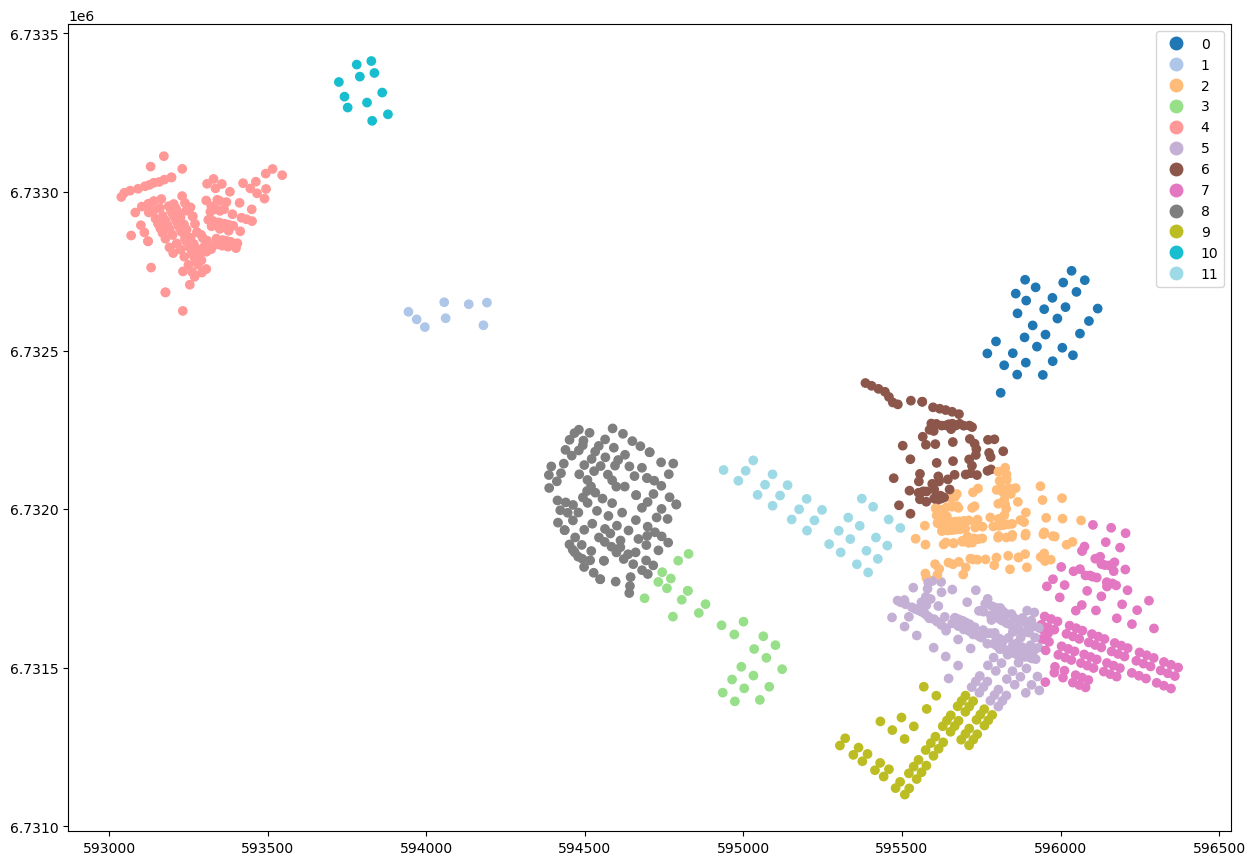

In [4]:
data.plot(
    column='group',
    categorical=True,
    cmap=cluster_colors,
    figsize=(15, 15),
    legend=True,
)

<AxesSubplot:xlabel='total_income_ln', ylabel='orthodox_proportion'>

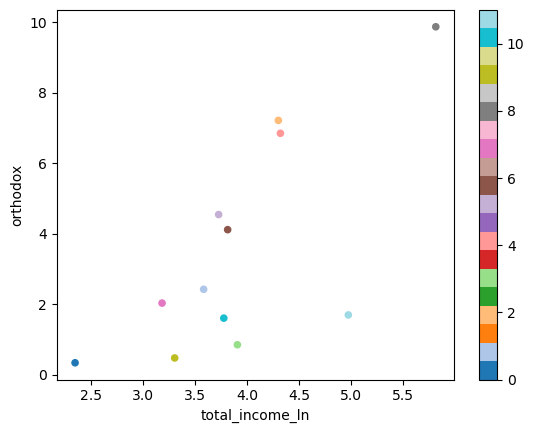

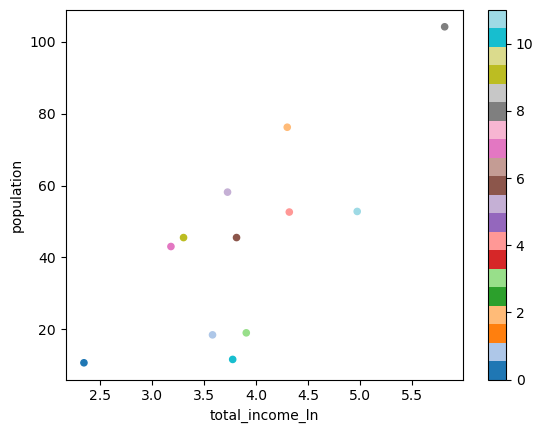

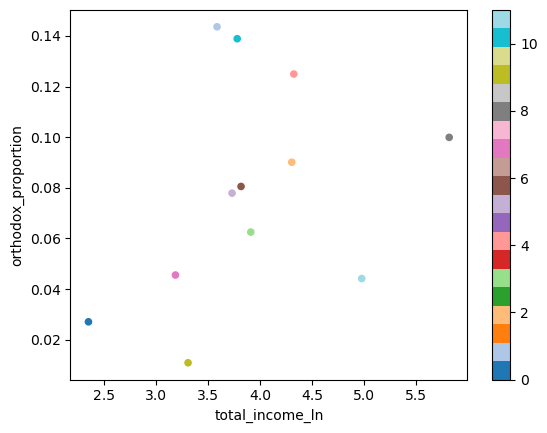

In [21]:
# data.plot.scatter(x='population', y='orthodox', c='group', cmap=cluster_colors)
# data.plot.scatter(x='total_income', y='orthodox', c='group', cmap=cluster_colors)
data_clustered = data.groupby('group').median().drop(columns=['index'])
data_clustered.plot.scatter(y='orthodox', x='total_income_ln', c=data_clustered.index.values, cmap=cluster_colors)
data_clustered.plot.scatter(y='population', x='total_income_ln', c=data_clustered.index.values, cmap=cluster_colors)
data_clustered.plot.scatter(y='orthodox_proportion', x='total_income_ln', c=data_clustered.index.values, cmap=cluster_colors)

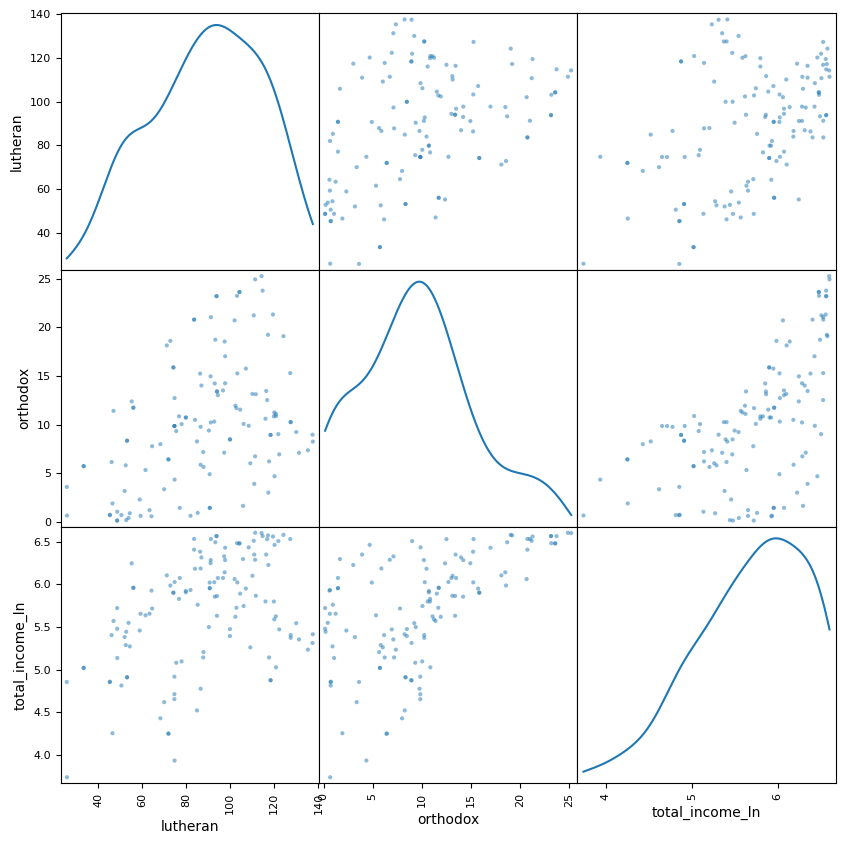

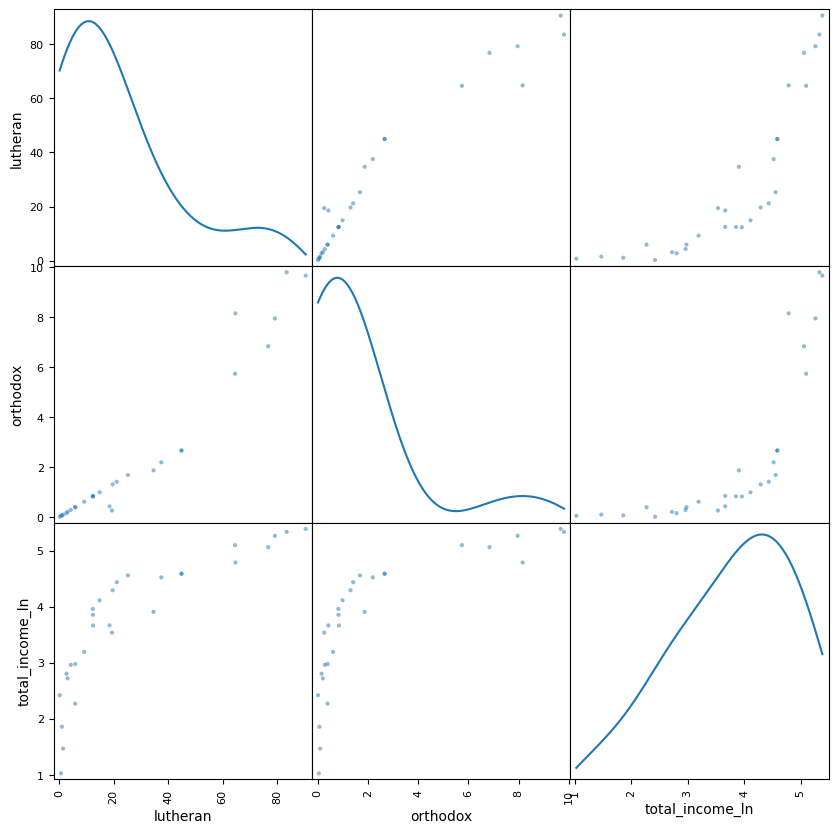

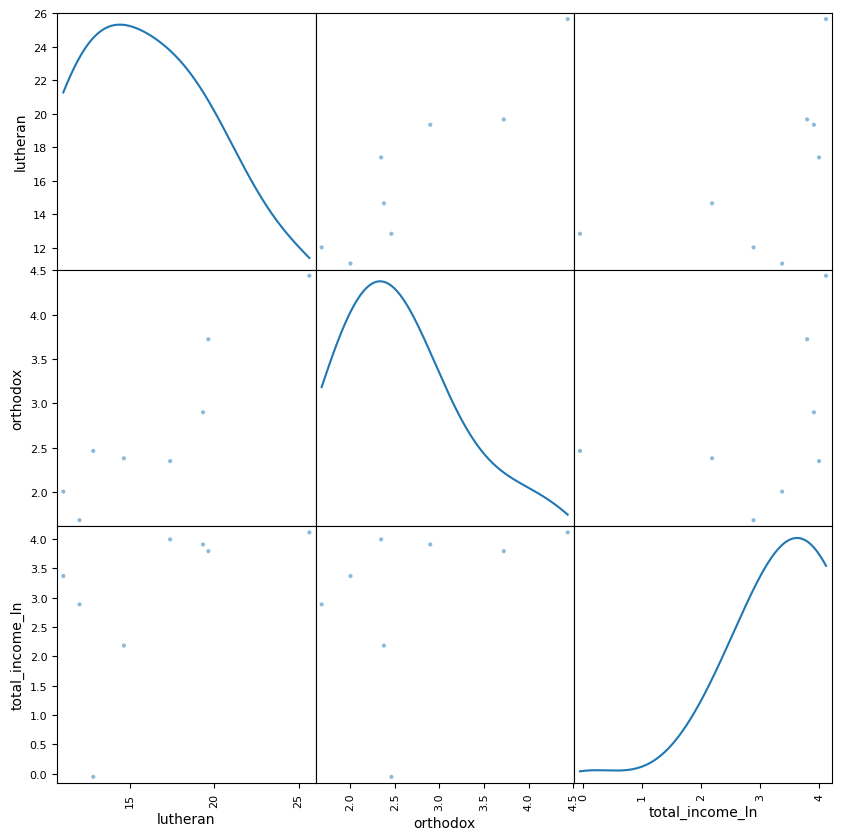

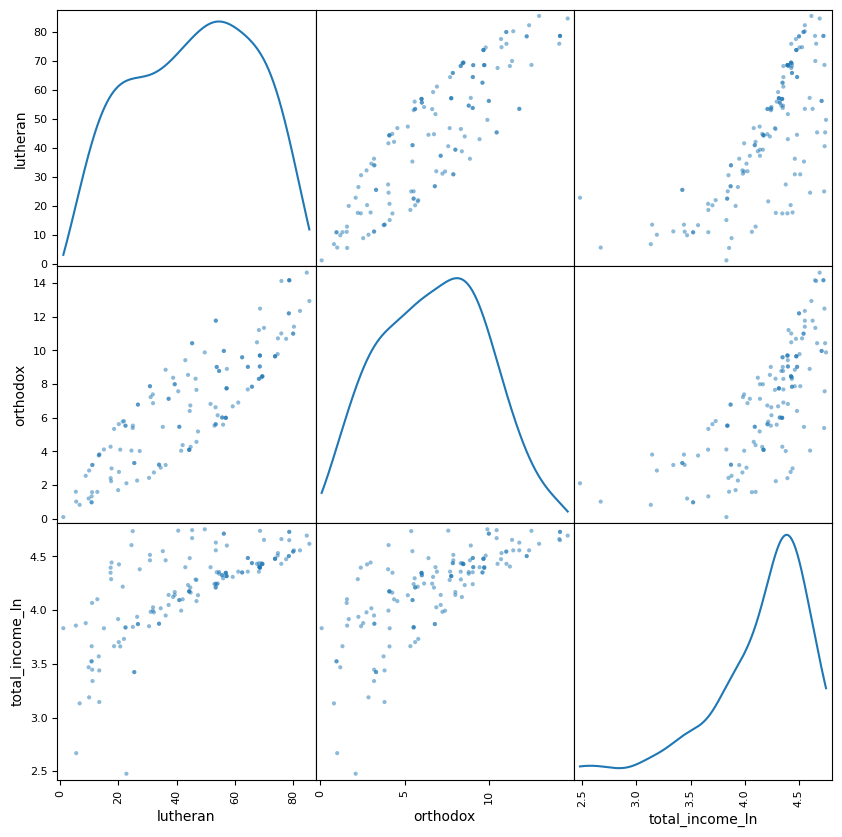

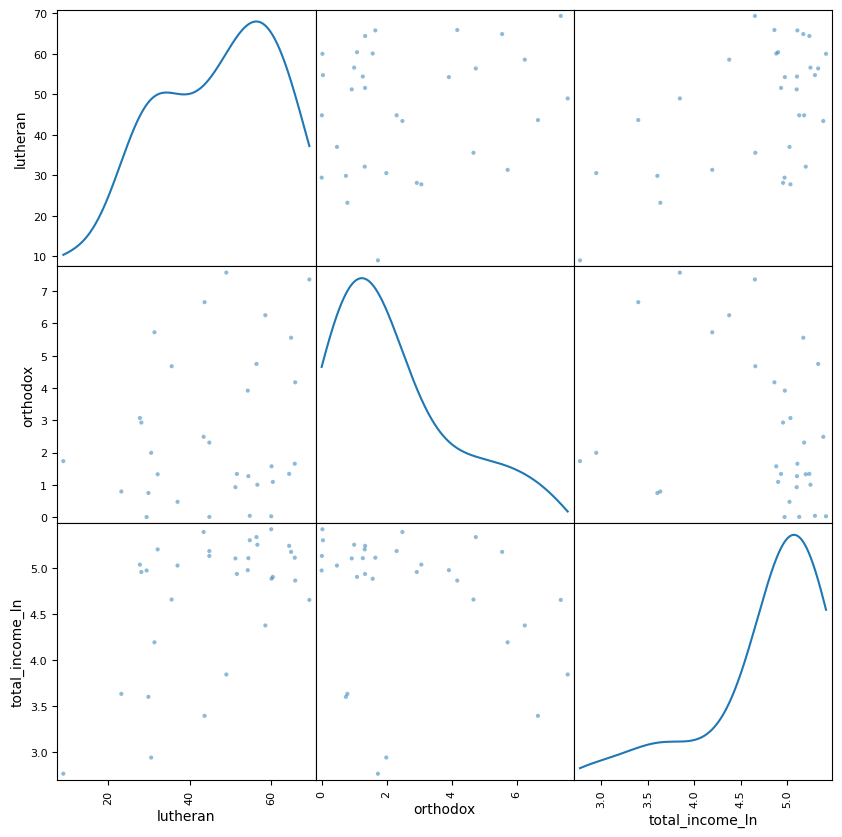

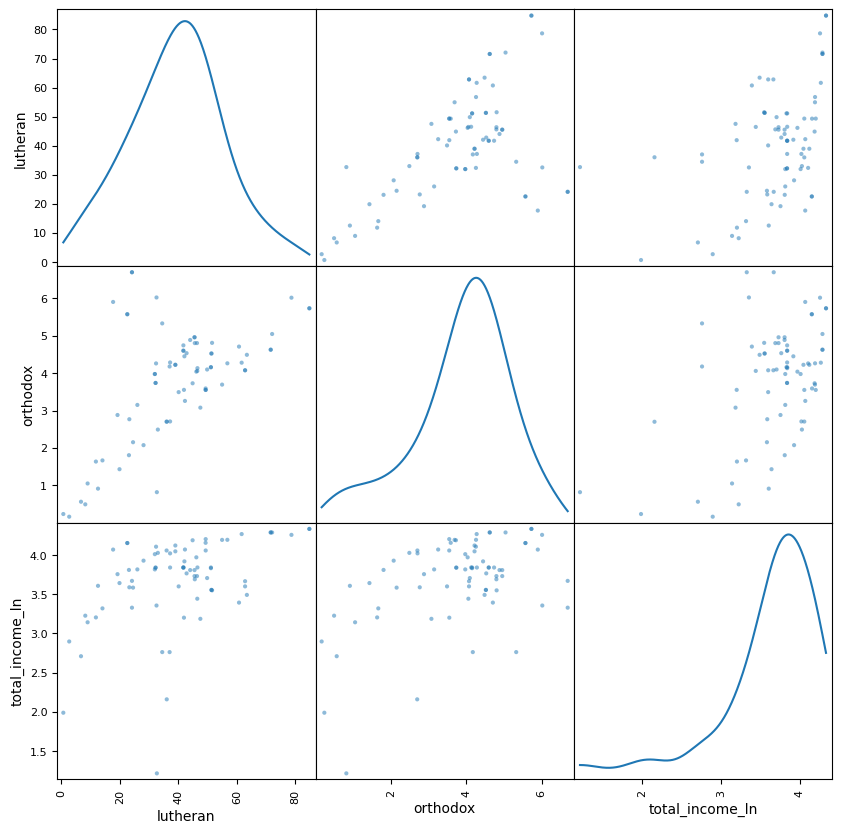

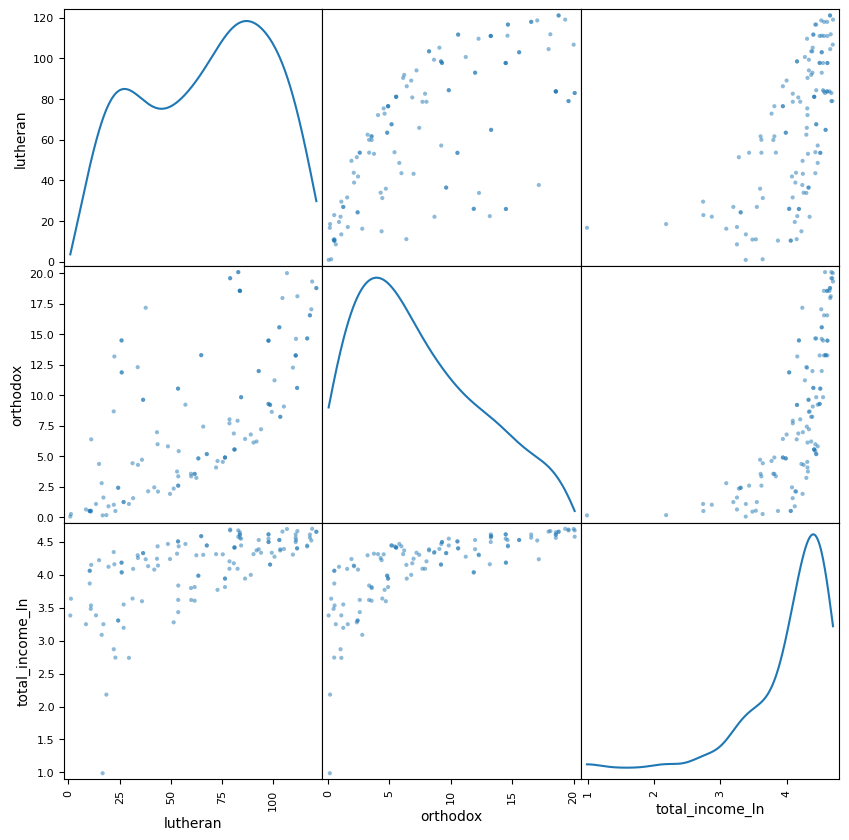

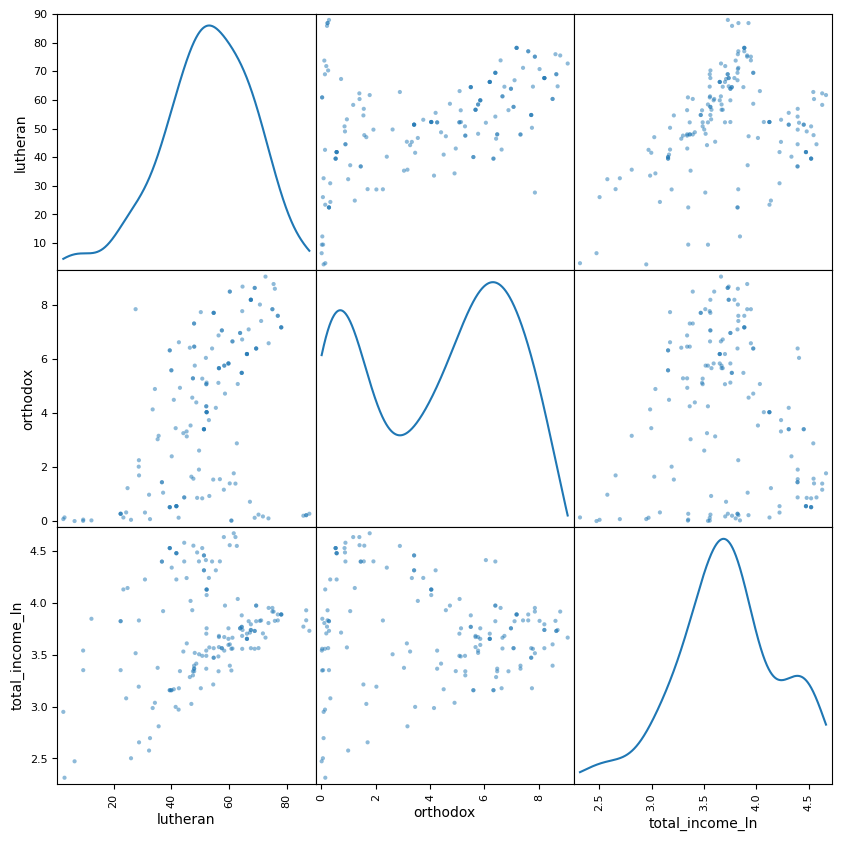

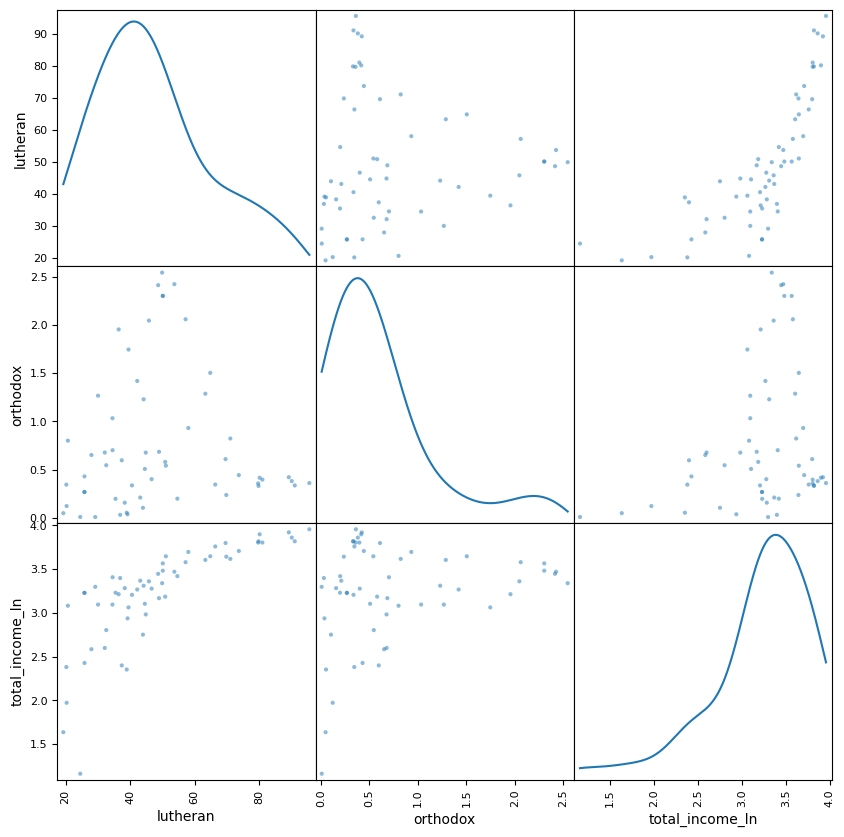

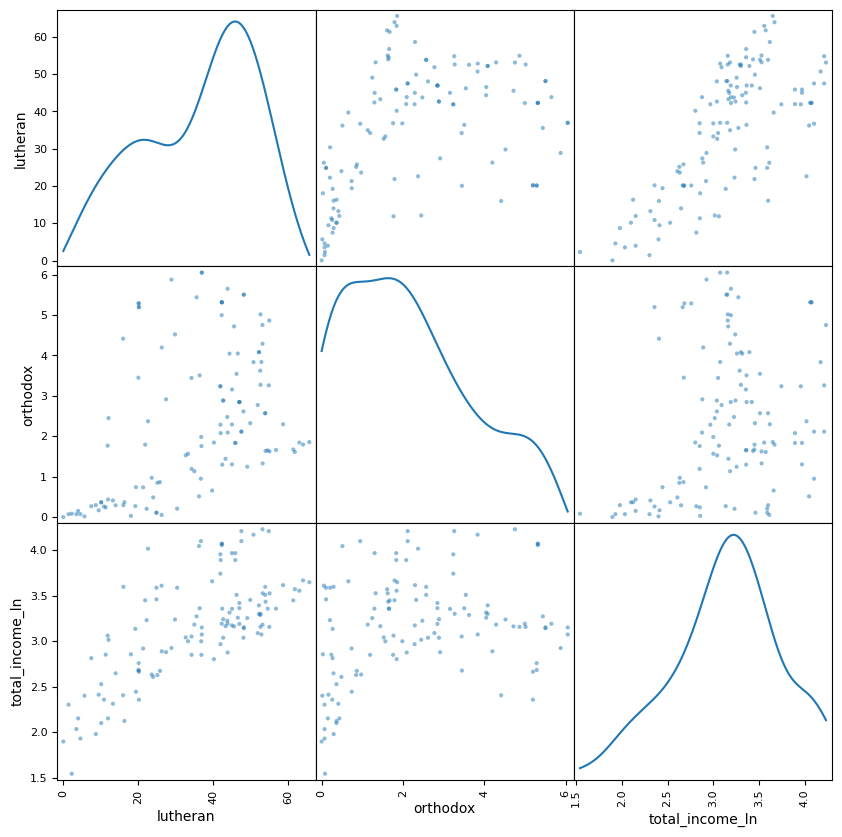

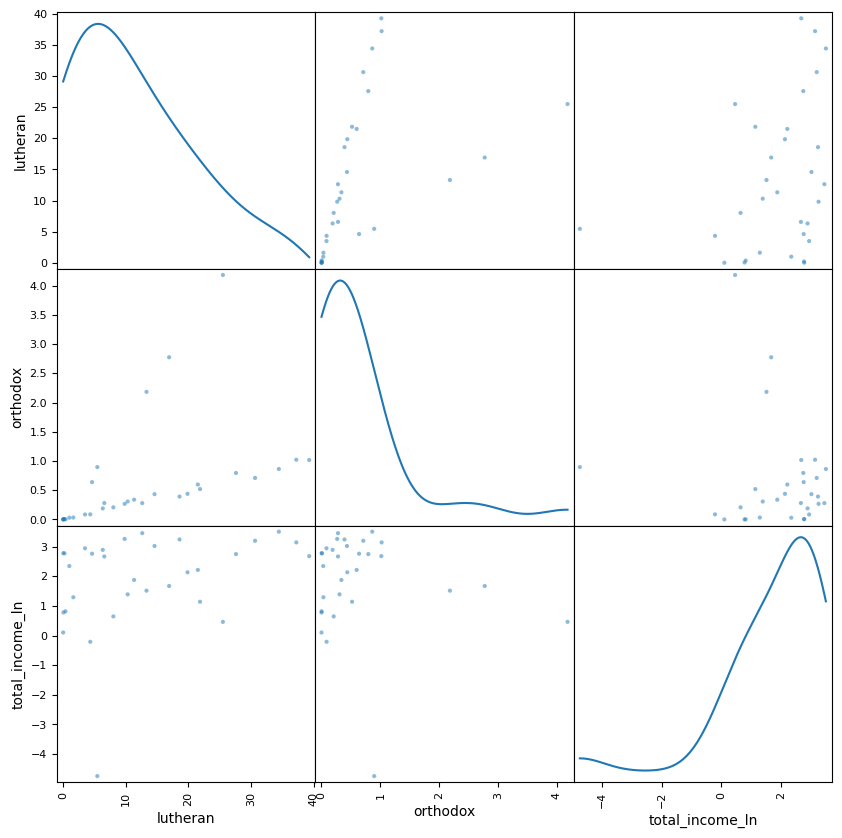

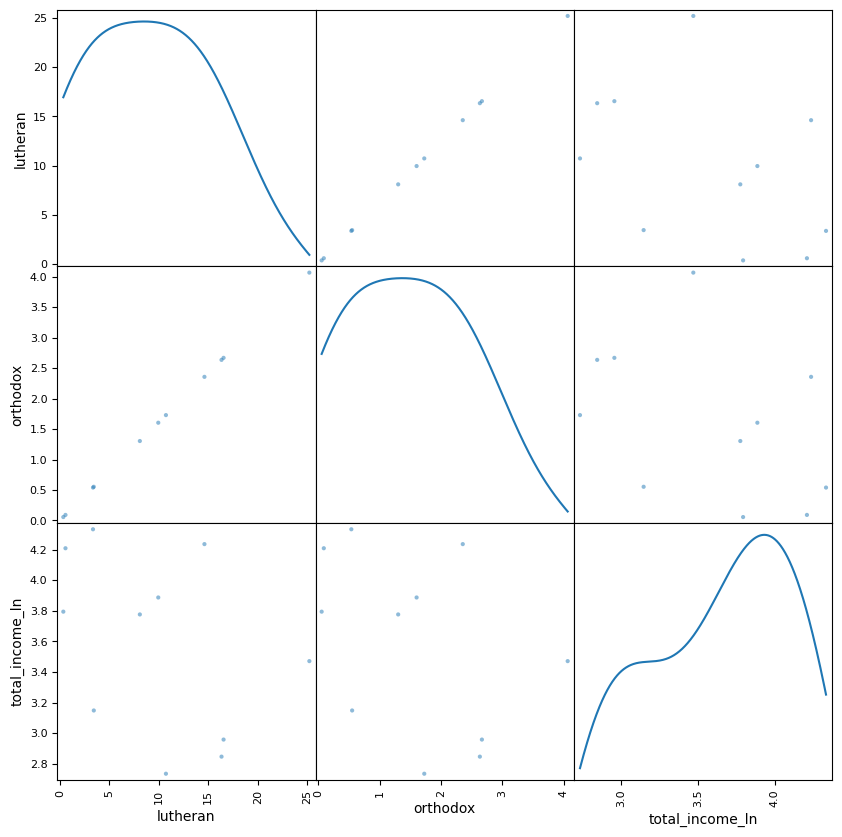

In [41]:
for i in data.group.unique():
    scatter_matrix(data.loc[data.group == i, ['lutheran', 'orthodox', 'total_income_ln']], diagonal='kde', figsize=(10, 10))

# Model with 12 geographical clusters (K-means)

$$ P_i \sim Gamma(μ_{P,i}, σ_P), i = 0, 1, ... 925 $$
$$ O_i \sim Gamma(μ_{O,i}, σ_O), i = 0, 1, ... 925 $$
$$ μ_{P,i} = exp ( [1 \; W]  β_{P,k[i]} ), i = 0, 1, ... 925, k = 0, 1, ... 11 $$
$$ μ_{O,i} = exp ( [1 \; W \; μ_{P,i}]  β_{O,k[i]} ), i = 0, 1, ... 925, k = 0, 1, ... 11 $$
$$ σ_P \sim Gamma(1, 0.2) $$
$$ σ_O \sim Gamma(1, 0.2) $$
$$ β_{P,k} \sim MvNormal \left( θ_P, \begin{bmatrix} 0.02 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ β_{O,k} \sim MvNormal \left( θ_O, \begin{bmatrix} 0.02 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ θ_{P} \sim MvNormal \left( \begin{bmatrix} 2.5 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.02 & 0 \\ 0 & 0.01 \end{bmatrix} \right) $$
$$ θ_{O} \sim MvNormal \left( \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.02 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.01 \end{bmatrix} \right) $$
where W is the natural logarithm of total income tax and i indicates the cadastral plot and k[i] the cluster of the cadastral plot

All gamma distribution parameters are means and standard deviations

In [23]:
with pm.Model() as model_3:
    W = pm.MutableData('W', data.total_income_ln)
    idx = data.group

    θ_P = pm.MvNormal('θ_P', np.array([2.5, 0]), np.array(np.diagflat([0.02, 0.01])), shape=2)
    θ_O = pm.MvNormal('θ_O', np.array([1, 0, 0]), np.array(np.diagflat([0.02, 0.01, 0.01])), shape=3)

    β_P = pm.MvNormal('β_P', θ_P, np.array(np.diagflat([0.02, 0.01])), shape=(N_CLUSTERS, 2))
    β_O = pm.MvNormal('β_O', θ_O, np.array(np.diagflat([0.02, 0.01, 0.01])), shape=(N_CLUSTERS, 3))

    μ_P = pm.Deterministic('μ_P', pm.math.exp(β_P[idx, 0] + β_P[idx, 1] * W))

    σ_P = pm.Gamma('σ_P', mu=1, sigma=0.2)
    P = pm.Gamma('P', mu=μ_P, sigma=σ_P, observed=data.population)

    μ_O = pm.math.exp(β_O[idx, 0] + β_O[idx, 1] * W + β_O[idx, 2] * μ_P)

    σ_O = pm.Gamma('σ_O', mu=1, sigma=0.2)
    O = pm.Gamma('O', mu=μ_O, sigma=σ_O, observed=data.orthodox)

    prior_3 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_3 = pm.sample(draws=1000, tune=1000, init="adapt_diag", return_inferencedata=True, target_accept=0.9, random_seed=SEED)
    posterior_prediction_3 = pm.sample_posterior_predictive(posterior_3, random_seed=SEED)

prior_3.to_netcdf(MODEL_DIR / 'model_prior')
posterior_3.to_netcdf(MODEL_DIR / 'model_posterior')
posterior_prediction_3.to_netcdf(MODEL_DIR / 'model_posterior_prediction')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_P, θ_O, β_P, β_O, σ_P, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6199 seconds.


PosixPath('../models/model_posterior_prediction')

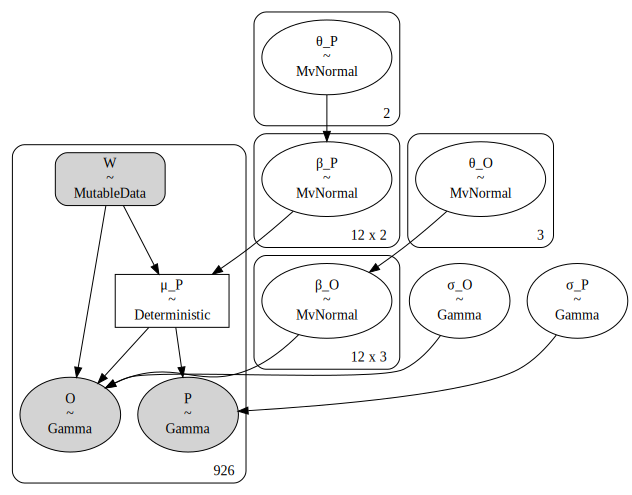

In [25]:
graph_3 = pm.model_to_graphviz(model_3)
graph_3

In [26]:
prior_3 = az.InferenceData.from_netcdf(MODEL_DIR / 'model_prior')
posterior_3 = az.InferenceData.from_netcdf(MODEL_DIR / 'model_posterior')
posterior_prediction_3 = az.InferenceData.from_netcdf(MODEL_DIR / 'model_posterior_prediction')

## Prior predictive check

Text(0, 0.5, 'μ_P')

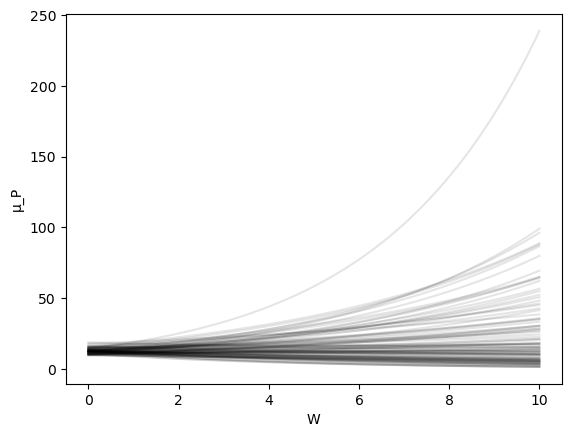

In [27]:
prior = prior_3['prior']
x = xr.DataArray(np.linspace(0, 10, 100), dims=["x"])
y = np.exp(prior['θ_P'][:,:,0] + prior['θ_P'][:,:,1] * x)
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel('W')
ax.set_ylabel('μ_P')

Text(0, 0.5, 'μ_O')

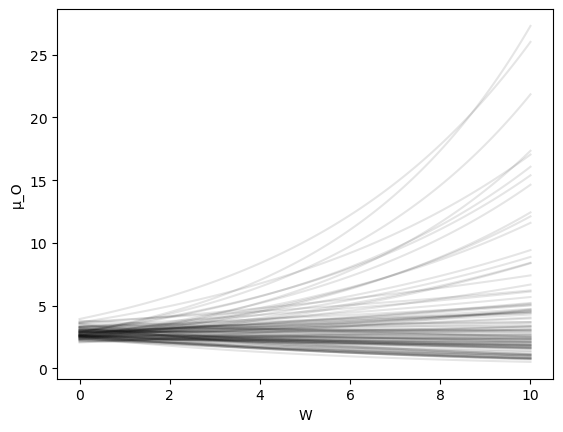

In [28]:
x = xr.DataArray(np.linspace(0, 10, 100), dims=["x"])
y = np.exp(prior['θ_O'][:,:,0] + prior['θ_O'][:,:,1] * x)
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel('W')
ax.set_ylabel('μ_O')

## Posterior predictive check

array([<AxesSubplot:xlabel='P / P'>, <AxesSubplot:xlabel='O / O'>],
      dtype=object)

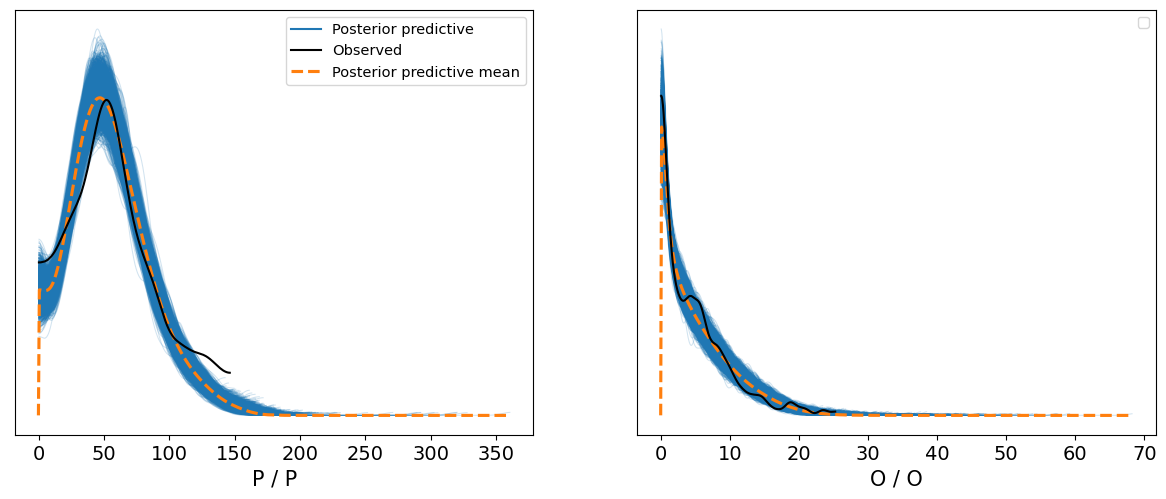

In [31]:
az.plot_ppc(posterior_prediction_3)

## Trace plots

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

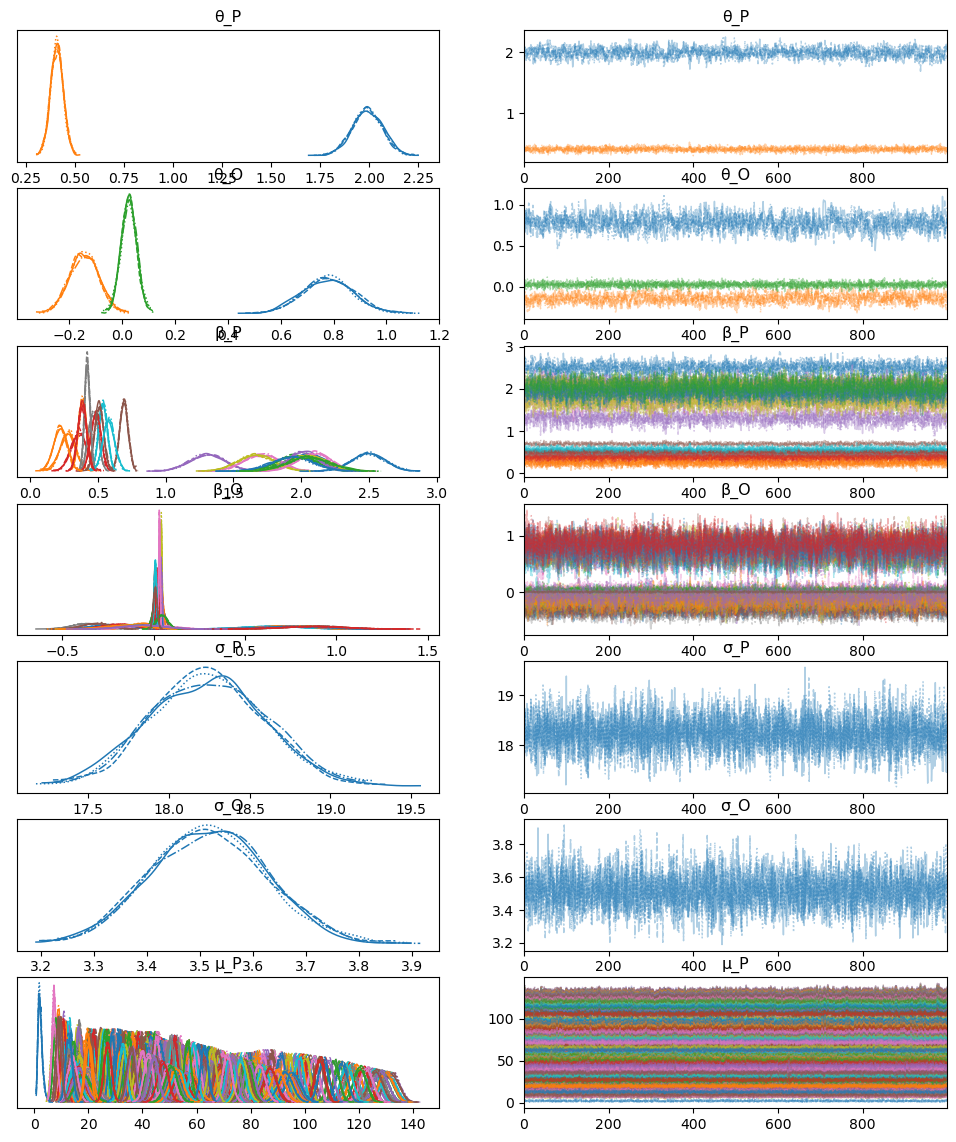

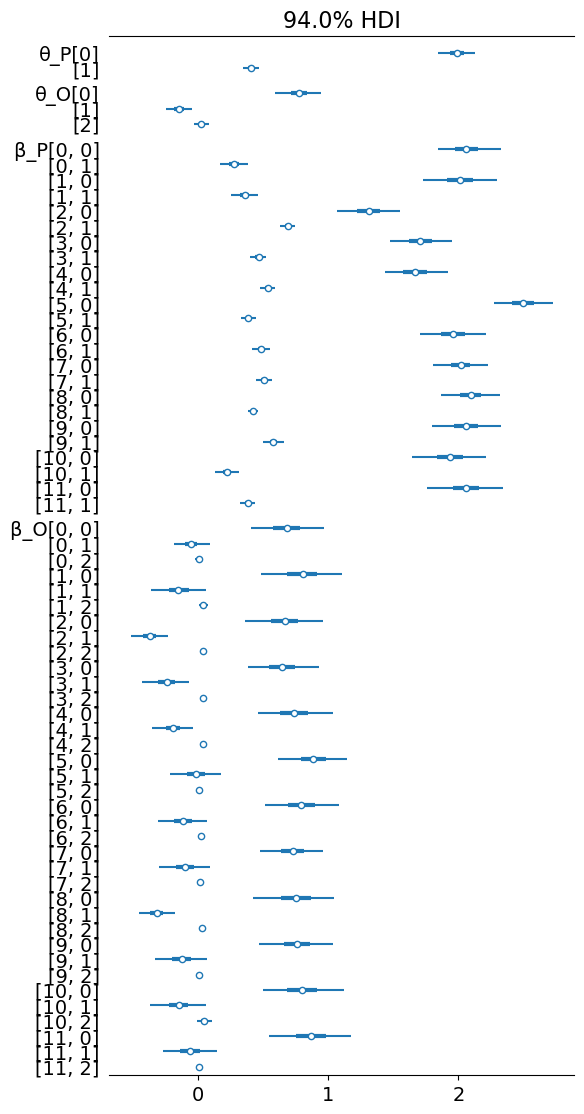

In [33]:
# az.plot_posterior(posterior_3)
az.plot_trace(posterior_3)
az.plot_forest(posterior_3, combined=True, hdi_prob=0.94, var_names=['~σ_P', '~σ_O', '~μ_P'])